In [1]:
import pathlib
import skimage
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
%matplotlib inline  

In [2]:
im_dir = pathlib.Path('F:/device/optics/32w_Realtime_test_5th/2')

In [3]:
temp_li = ['Low Temp', 'High Temp']
x_range = slice(400, 1900)
y_range = slice(400, 1900)
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

In [4]:
ch_dict = {
    0: 'CalRed',
    1: 'FAM',
    2: 'Q670',
    3: 'HEX'
}

In [5]:
im_dict = {}
for ch in range(4):
    ch_name = ch_dict[ch]
    im_dict[ch_name] = {}
    for t in range(2):
        im_dict[ch_name][temp_li[t]] = {}
        for c in range(45):
            im_dict[ch_name][temp_li[t]][c] = {}
            fpath = im_dir/f'{c}_{t}_{ch}.jpg'
            im = np.array(Image.open(fpath))
            im_cropped = im[x_range, y_range]

            im_gray = im_cropped[:, :, 0] + im_cropped[:, :, 1] + im_cropped[:, :, 2]

            thresh = skimage.filters.threshold_otsu(im_gray)
            threshed_im = im_gray > thresh
            im_dict[ch_name][temp_li[t]][c]['thresh'] = threshed_im

            bw = skimage.morphology.closing(threshed_im, skimage.morphology.disk(3))
            bw2 = skimage.morphology.opening(bw, skimage.morphology.disk(3))
            cleared = skimage.segmentation.clear_border(bw2)
            im_labeled = skimage.measure.label(cleared)
            im_dict[ch_name][temp_li[t]][c]['labeled'] = im_labeled
            
            region_raw_dict = {}
            for region in skimage.measure.regionprops(im_labeled, intensity_image=im_gray):
                region_raw_dict[region.area] = region
            im_dict[ch_name][temp_li[t]][c]['regions'] = region_raw_dict
        

In [6]:
result_dict = {}
for temp in temp_li:
    result_dict[temp] = {}
    for ch in ch_dict.values():
        result_dict[temp][ch] = {}

In [7]:
im_dict[ch][temp][44]['regions']

{831: <skimage.measure._regionprops._RegionProperties at 0x22b0aa11c18>,
 46: <skimage.measure._regionprops._RegionProperties at 0x22b0aa11a20>,
 617: <skimage.measure._regionprops._RegionProperties at 0x22b0aa23198>,
 320: <skimage.measure._regionprops._RegionProperties at 0x22b0aa23208>,
 3966: <skimage.measure._regionprops._RegionProperties at 0x22b0aa23668>,
 4757: <skimage.measure._regionprops._RegionProperties at 0x22b0aa23630>,
 10029: <skimage.measure._regionprops._RegionProperties at 0x22b0aa230b8>,
 10103: <skimage.measure._regionprops._RegionProperties at 0x22b0aa238d0>,
 3596: <skimage.measure._regionprops._RegionProperties at 0x22b0aa23860>,
 5049: <skimage.measure._regionprops._RegionProperties at 0x22b0aa23710>,
 9089: <skimage.measure._regionprops._RegionProperties at 0x22b0aa230f0>,
 9158: <skimage.measure._regionprops._RegionProperties at 0x22b0aa231d0>,
 3522: <skimage.measure._regionprops._RegionProperties at 0x22b0aa232b0>,
 4434: <skimage.measure._regionprops._Reg

In [8]:
row = list('ABCD')[::-1]
result_dict = {'well_grid': {}}
for temp in temp_li:
    result_dict['well_grid'][temp] = {}

for ch in ch_dict.values():
    for temp in temp_li:
        regions = im_dict[ch][temp][44]['regions']
        
        areas_li = []
        for area, region in regions.items():
            areas_li.append(area)
            
        sorted_region_key = list(areas_li)
        sorted_region_key.sort(reverse=True)
        
        minr_li = []
        minc_li = []
        maxr_li = []
        maxc_li = []
        for key in sorted_region_key[:16]:
            region = regions[key]
            minr, minc, maxr, maxc = region.bbox
            minr_li.append(minr)
            minc_li.append(minc)
            maxr_li.append(maxr)
            maxc_li.append(maxc)
        minr_li.sort()
        top = minr_li[0]
        minc_li.sort()
        left = minc_li[0]
        maxr_li.sort()
        bottom = maxr_li[-1]
        maxc_li.sort()
        right = maxc_li[-1]

        well_box = [top-50, left-50, bottom+50, right+50]
        y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
        x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
        pts_x = []
        pts_y = []
        for x in x_li:
            for y in y_li:
                pts_x.append(x)
                pts_y.append(y)
        pts_li = list(zip(pts_x, pts_y))
        
        i = 0
        well_location_dict = {}
        for x in range(4):
            for y in range(4):
                key = row[y]+str(x+1)
                top_left_pt = pts_li[i+y+x]
                bottom_right_pt = pts_li[i+y+x+6]
                well_location_dict[key] = [top_left_pt[1], top_left_pt[0], bottom_right_pt[1], bottom_right_pt[0]]
            i += 4
        result_dict['well_grid'][temp][ch] = well_location_dict
        
            

In [9]:
result_dict['well_grid']['High Temp']['Q670']

{'D1': [141.0, 379.0, 377.0, 606.75],
 'C1': [377.0, 379.0, 613.0, 606.75],
 'B1': [613.0, 379.0, 849.0, 606.75],
 'A1': [849.0, 379.0, 1085.0, 606.75],
 'D2': [141.0, 606.75, 377.0, 834.5],
 'C2': [377.0, 606.75, 613.0, 834.5],
 'B2': [613.0, 606.75, 849.0, 834.5],
 'A2': [849.0, 606.75, 1085.0, 834.5],
 'D3': [141.0, 834.5, 377.0, 1062.25],
 'C3': [377.0, 834.5, 613.0, 1062.25],
 'B3': [613.0, 834.5, 849.0, 1062.25],
 'A3': [849.0, 834.5, 1085.0, 1062.25],
 'D4': [141.0, 1062.25, 377.0, 1290.0],
 'C4': [377.0, 1062.25, 613.0, 1290.0],
 'B4': [613.0, 1062.25, 849.0, 1290.0],
 'A4': [849.0, 1062.25, 1085.0, 1290.0]}

In [10]:
def get_well_loc(x, y, pts_center, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well

In [11]:
def get_grid_loc(x, y, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well

In [12]:
result_dict['well_grid']['High Temp']['Q670']['D1']

[141.0, 379.0, 377.0, 606.75]

In [13]:
t = 1
c = 1

sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
sorted_region_key.sort(reverse=True)

li = []
for key in sorted_region_key:
    region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
    y, x = region_obj.centroid
    li.append([x, y])
li.sort()
    

In [14]:
li

[[107.18464427289797, 1050.1506363446692],
 [157.1125, 1143.6333333333334],
 [476.68474114441415, 277.36784741144413],
 [479.0418785121755, 512.2459191865132],
 [481.5015257407225, 749.9176100009844],
 [485.44481163251817, 973.817014446228],
 [708.854743792163, 277.7064733744797],
 [709.7019195275009, 509.00719822812846],
 [714.0926637124569, 744.3110782865583],
 [714.5836835865933, 965.3860329776916],
 [938.5597743214395, 274.44937480939313],
 [940.5081021464325, 504.62280478493255],
 [944.5071968520244, 736.2946049497774],
 [945.0168616655196, 956.5922229869236],
 [1164.5480511282942, 729.572510651728],
 [1164.8800360793746, 950.3616957306074],
 [1166.0648793565683, 501.25857908847183],
 [1167.875796178344, 265.33503184713373]]

In [15]:
for x, y in li:
    grid = get_grid_loc(x, y, result_dict['well_grid']['High Temp']['Q670'])
    print(grid, '>>>', x, y)

None >>> 107.18464427289797 1050.1506363446692
None >>> 157.1125 1143.6333333333334
D1 >>> 476.68474114441415 277.36784741144413
C1 >>> 479.0418785121755 512.2459191865132
B1 >>> 481.5015257407225 749.9176100009844
A1 >>> 485.44481163251817 973.817014446228
D2 >>> 708.854743792163 277.7064733744797
C2 >>> 709.7019195275009 509.00719822812846
B2 >>> 714.0926637124569 744.3110782865583
A2 >>> 714.5836835865933 965.3860329776916
D3 >>> 938.5597743214395 274.44937480939313
C3 >>> 940.5081021464325 504.62280478493255
B3 >>> 944.5071968520244 736.2946049497774
A3 >>> 945.0168616655196 956.5922229869236
B4 >>> 1164.5480511282942 729.572510651728
A4 >>> 1164.8800360793746 950.3616957306074
C4 >>> 1166.0648793565683 501.25857908847183
D4 >>> 1167.875796178344 265.33503184713373


In [16]:
region_sum_dict = {}
for t in range(2):
    temp = temp_li[t]
    region_sum_dict[temp] = {}
    for ch in ch_dict.values():
        region_sum_dict[temp][ch] = {}
        for well in well_location_dict.keys():
            region_sum_dict[temp][ch][well] = [0]*45

        for c in range(45):
            sorted_region_key = list(im_dict[ch][temp][c]['regions'].keys())
            sorted_region_key.sort(reverse=True)

            center_at_cycle = {}
            for key in sorted_region_key:
                region_obj = im_dict[ch][temp][c]['regions'][key]
                y, x = region_obj.centroid
                grid = get_grid_loc(x, y, result_dict['well_grid'][temp][ch])
                if 'High' in temp and 'Q' in ch and c == 1:
                    print(grid, x, y)
                if grid is None:
                    continue
            
                if grid not in center_at_cycle.keys():
                    center = [x, y]
                    center_at_cycle[grid] = center
                else:
                    center = center_at_cycle[grid]
                well = get_well_loc(x, y, center, result_dict['well_grid'][temp][ch])

                if well is not None:
                    val = region_sum_dict[temp][ch][well][c]
                    val += region_obj.intensity_image.sum()
                    region_sum_dict[temp][ch][well][c] = val

result_dict['rfu_sum'] = region_sum_dict


C3 940.5081021464325 504.62280478493255
C2 709.7019195275009 509.00719822812846
A1 485.44481163251817 973.817014446228
B1 481.5015257407225 749.9176100009844
B2 714.0926637124569 744.3110782865583
B3 944.5071968520244 736.2946049497774
A2 714.5836835865933 965.3860329776916
A3 945.0168616655196 956.5922229869236
C1 479.0418785121755 512.2459191865132
C4 1166.0648793565683 501.25857908847183
D2 708.854743792163 277.7064733744797
A4 1164.8800360793746 950.3616957306074
D3 938.5597743214395 274.44937480939313
B4 1164.5480511282942 729.572510651728
None 107.18464427289797 1050.1506363446692
D1 476.68474114441415 277.36784741144413
D4 1167.875796178344 265.33503184713373
None 157.1125 1143.6333333333334


In [17]:
ch_dict.values()

dict_values(['CalRed', 'FAM', 'Q670', 'HEX'])

In [18]:
dict_before = pd.read_excel('F:/device/optics/32w_Realtime_test_5th/5차 2번카메라.xlsx', sheet_name=None, header=None)
dict_before.keys()

odict_keys(['fam60', 'hex60', 'cal60', 'qua60', 'fam72', 'hex72', 'cal72', 'qua72'])

In [19]:
df = dict_before['fam60']
df

0       1       2       3       4       5       6       7       8   \
0   45841  122714  115249   47317  159241  354639  360273  159439  217330   
1   43353  116732  112159   46362  149806  338644  352249  158645  205554   
2   45011  122730  114589   46271  150569  342402  353387  160476  204505   
3   43897  124110  117059   45744  147735  339499  351869  161300  199116   
4   43311  123093  116435   44464  144758  335128  350619  160355  196681   
5   31191   98474   99840   37459  124177  307261  323422  151217  183874   
6   31628  105131  101799   37672  122126  303434  321620  152215  182142   
7   30875  103588  102367   37854  121517  303578  320172  153096  179439   
8   30402  104079  103481   37183  120726  300185  318065  151311  178150   
9   29934  103800  104377   35991  119772  299734  318194  152334  176492   
10  29293  102885  104478   34589  117247  298880  317068  151771  175497   
11  29647  102049  103796   33380  117223  296149  317512  151649  173169   
12  29922  102939  106518   34482  116100  295130  314883  151220  174100   
13  29666  100954  106761   33680  115127  292644  312467  149898  173124   
14  29096  101773  106813   33765  115023  292895  310190  147951  171816   
15  28806  100342  107214   33782  114039  291975  312184  149547  170679   
16  27884  100425  106361   33221  112331  287501  307732  148870  171159   
17  27588  100437  106970   33886  111896  287728  307865  147905  169649   
18  27765   99110  108314   33348  112520  286749  307214  149026  168287   
19  27647  100504  107134   34013  110913  286731  305908  147854  168411   
20  27044   98627  105557   33808  109961  283909  304754  146834  166088   
21  27406   94256  104612   34147  110547  283073  303956  146528  166944   
22  27284   93584  105242   33998  109430  281012  303709  146317  165594   
23  27928   92691  106548   34067  108535  281946  301988  146010  167387   
24  27420   94055  104756   34815  108640  280270  302645  143403  165775   
25  26724   91330  104926   34162  108272  278595  300995  143729  163441   
26  26793   93011  104515   33816  107918  277802  299252  143817  164154   
27  27155   92279  104131   34033  108233  279409  303195  143488  164183   
28  26296   93090  105036   33632  108323  279046  301134  143431  163945   
29  26441   93664  105619   34955  108295  280049  304676  144730  164209   
30  26597   94107  107341   35053  108669  280838  308246  146718  164415   
31  27154   95531  109732   35454  110515  285669  314304  151203  166526   
32  27695   98610  112691   36757  111748  289476  322809  154831  169670   
33  28846  100972  119491   38929  116747  300360  336877  162557  173696   
34  29847  105139  124283   40707  121137  309467  345679  167746  181549   
35  31804  115376  132316   43473  124683  322059  361691  178486  186866   
36  33901  122465  138858   46909  135056  336194  379886  187257  198125   
37  36707  132742  150134   51254  141770  354307  403731  198111  205635   
38  36388  143986  168619   65703  145983  386086  452858  229784  214699   
39  41066  158039  182936   72926  158607  412113  483222  247717  227118   
40  46620  174309  198071   80013  173168  441800  514001  265386  241679   
41  56928  200979  230864   97650  202536  496174  573760  303142  279821   
42  63025  215882  248103  107564  216563  521270  599146  322193  298733   
43  68074  225932  261414  114369  229829  542243  622186  337259  313804   

        9       10      11      12      13      14      15  
0   411200  387879  173026  151721  316275  317554  185391  
1   399409  386515  176443  150016  319358  322322  188086  
2   402995  378857  174305  151727  320317  323005  184624  
3   399747  377233  175199  151718  323114  325385  186847  
4   396073  376349  173881  151105  321844  324471  188692  
5   381807  384910  175358  150932  332446  337118  195266  
6   381293  390261  174429  148718  331193  336435  193579  
7   380587  389988  174696  149942  335531  338766  1

In [20]:
len(df)

44

In [21]:
map_dict = {
    'CalRed': 'cal',
    'FAM': 'fam',
    'HEX': 'hex',
    'Q670': 'qua',
    'L': '60',
    'H': '72'
}
row = list('ABCD')[::-1]
col_li = []
for y in range(4):
    for x in range(4):
        key = row[y]+str(x+1)
        col_li.append(key)
col_li

['D1',
 'D2',
 'D3',
 'D4',
 'C1',
 'C2',
 'C3',
 'C4',
 'B1',
 'B2',
 'B3',
 'B4',
 'A1',
 'A2',
 'A3',
 'A4']

In [22]:
result_dict['rfu_sum']['Low Temp'].keys()

dict_keys(['CalRed', 'FAM', 'Q670', 'HEX'])

In [23]:
pd.DataFrame(result_dict['rfu_sum']['High Temp']['Q670'])

D1      C1      B1      A1      D2      C2      B2      A2      D3  \
0    69337  175355  261497  235952  156576  285917  268137  242476  136991   
1    70239  172300  256367  258297  160509  284157  270545  246230  143237   
2    71155  169188  248749  268789  164241  285580  273186  253820  147621   
3    69920  168387  246066  288089  161323  285816  272888  268090  149830   
4    69979  150190  208369  192784  171199  286551  273840  216701  166147   
5    87014  155815  210832  194836  201316  303120  292503  227826  191999   
6    72288  142430  199961  188429  178064  288210  291991  224801  170454   
7    71672  140096  198231  188074  186075  287544  291768  232275  169930   
8    87966  147977  204827  207540  213092  293753  293301  236608  205968   
9    74270  141095  201730  206752  189192  288048  296730  240913  182432   
10   72828  141205  200537  208119  187803  285090  293070  240279  194402   
11   73256  138025  199918  210967  193753  288140  292635  246796  195401   
12   83445  141909  195854  207964  210849  287286  286133  236491  222435   
13   74959  134067  193575  203388  194535  288584  284567  235249  200655   
14   87823  141413  192770  208958  214732  288789  282832  236688  226146   
15   69544  131076  190562  209338  188418  280453  282660  238812  193854   
16   70832  132254  190349  207317  186807  280982  279698  244057  197098   
17   68824  130399  193147  198625  186135  281780  278665  240307  198205   
18   68080  132803  189375  213842  190828  280544  276194  244202  199144   
19   70077  129660  189877  206987  181853  277839  276443  241627  200635   
20   73625  131224  184457  208796  186411  277872  275456  245585  200269   
21   77879  130237  186364  206436  191965  280712  276756  241883  210178   
22   72268  129375  187101  204737  189930  277107  273899  242913  202672   
23   76729  139276  194727  223223  199487  278141  267098  249822  220906   
24   80708  137043  192803  224440  194390  281169  265528  246583  216974   
25   80630  139862  196816  221373  200436  280922  269076  247100  219879   
26   75202  139631  193209  228164  193935  279506  267900  249772  219415   
27   72855  136865  190993  224839  196921  280159  266595  249361  217602   
28   74821  138639  192887  220941  199903  284231  270999  245879  222902   
29   78296  136736  197572  222891  200318  289412  268717  251149  227730   
30   79937  138328  198617  222450  201738  291047  276283  251097  231681   
31   75634  142925  198389  224747  202461  294570  281368  249932  234597   
32   84113  152859  202161  230572  215225  305643  293823  261620  246192   
33   73824  146095  199551  220822  202382  306397  298911  262048  234445   
34   85871  152145  210157  231607  210805  321237  319393  272959  251039   
35  103703  178022  237089  249952  251518  353750  349665  293358  270235   
36   90552  174628  225690  245091  241794  353472  358255  301090  278402   
37  101713  195811  257496  271202  260443  381861  394889  319017  296850   
38  112906  211414  280357  292676  291093  434753  438637  358172  331253   
39  112830  219878  286423  301653  301794  451350  455719  373628  341379   
40  107780  227160  301262  309333  289741  460692  478644  389179  312426   
41  143351  256193  330930  339321  343814  495915  495833  411415  371262   
42  157874  275870  344841  363081  359000  512301  508774  432763  386713   
43  162008  286997  358404  371769  373566  525962  510840  441059  396258   
44  134684  278080  355460  375446  339004  516523  511416  451777  354621   

        C3      B3      A3      D4      C4      B4      A4  
0   312103  250441  238478   59361  178342  155525  177062  
1   310038  249697  246493   56544  181413  157757  178001  
2   313004  248835  247558   61616  186266  152890  173354  
3   314469  250069  249560   57920  182830  157154  176824  
4   294363  227563  211646   73625  171832  137306  156966  
5   312925  250419  216622   88086  181683  143306  1

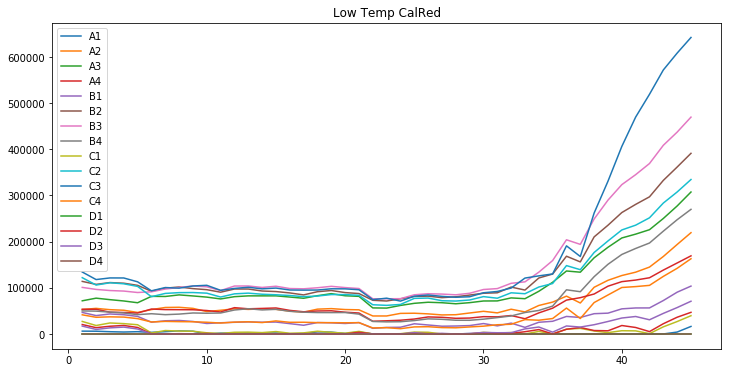

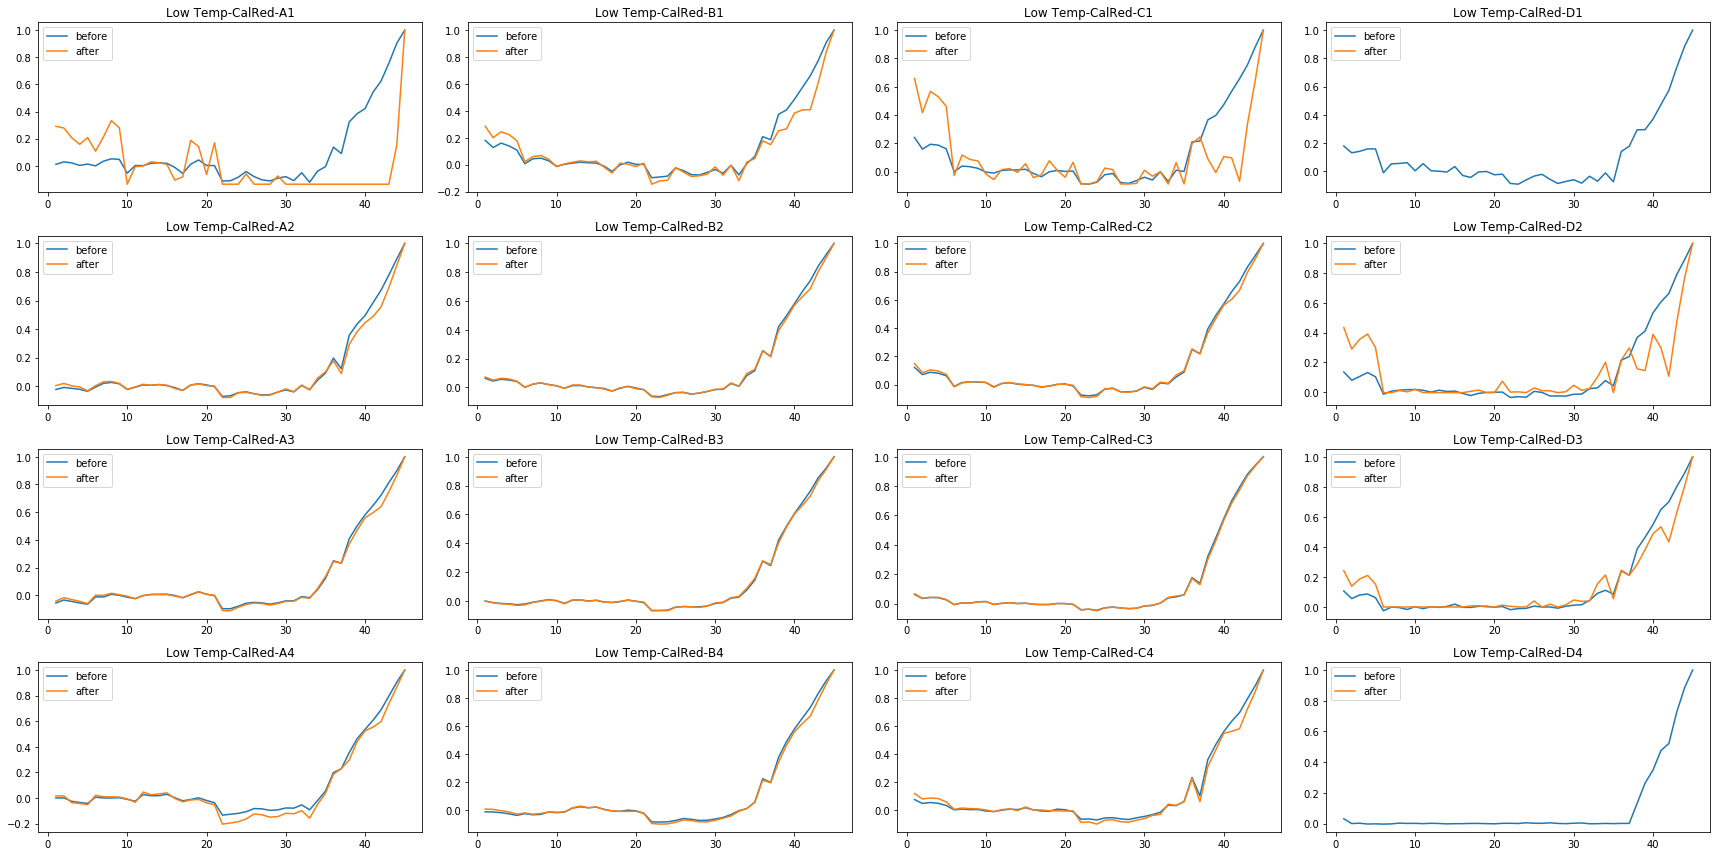

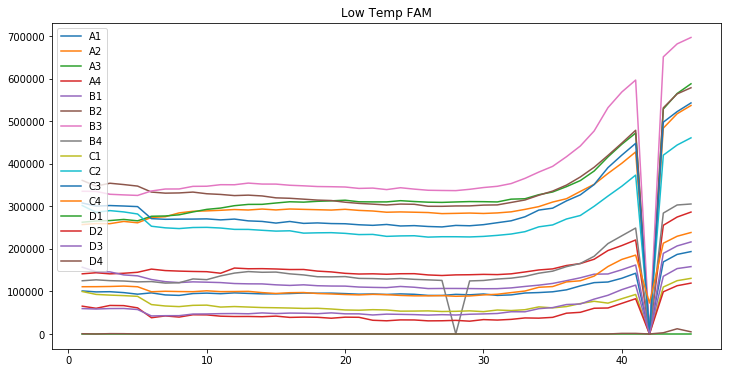

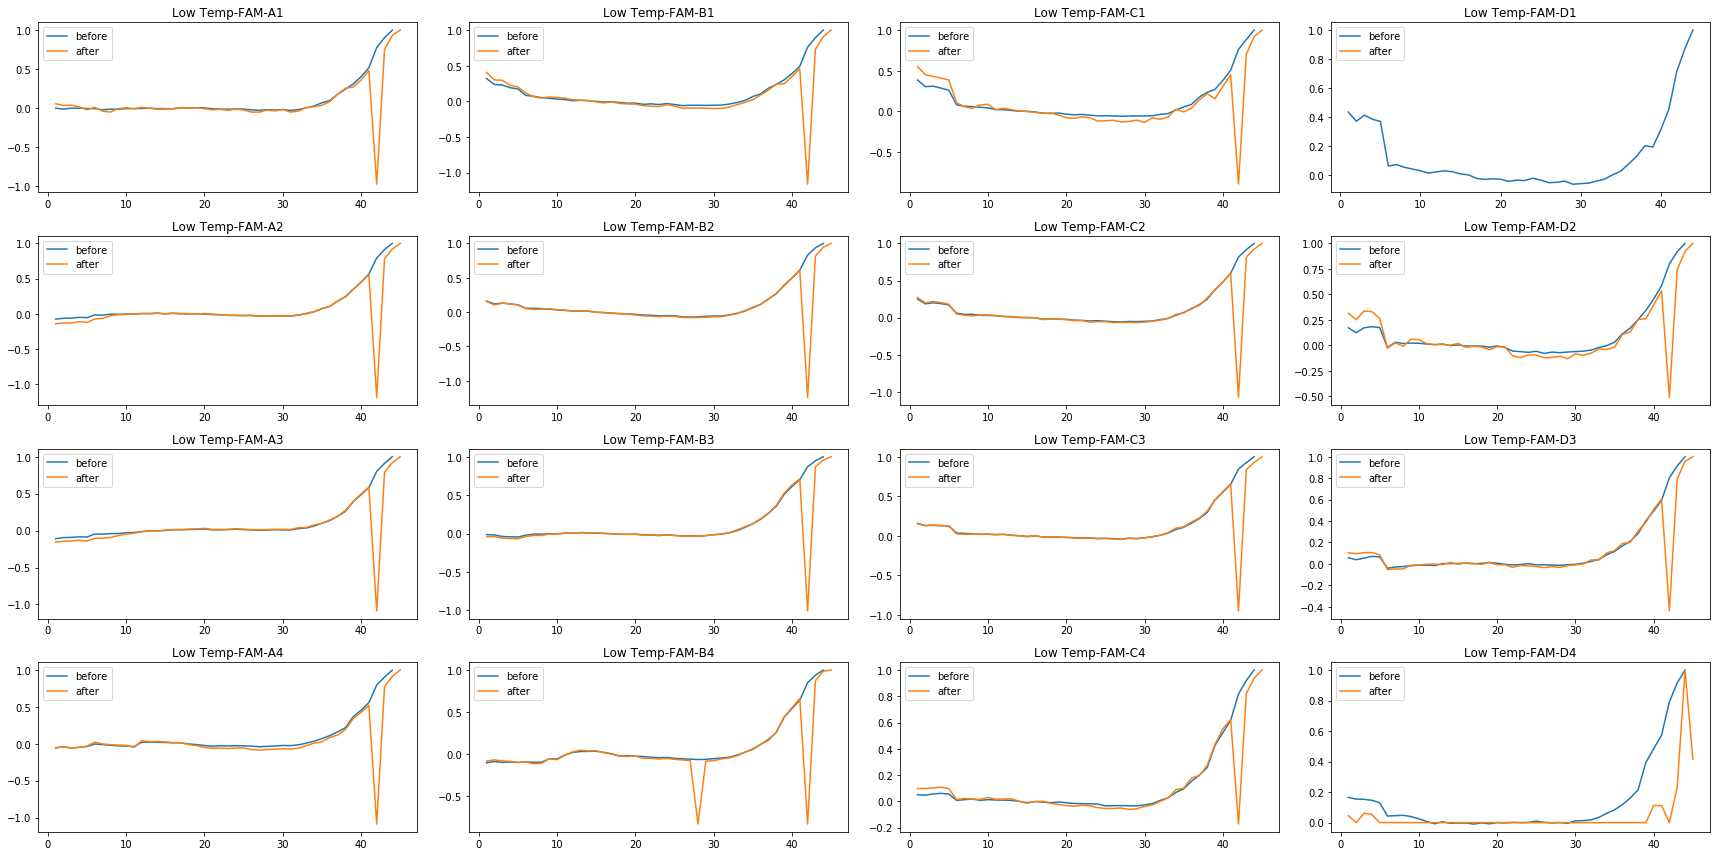

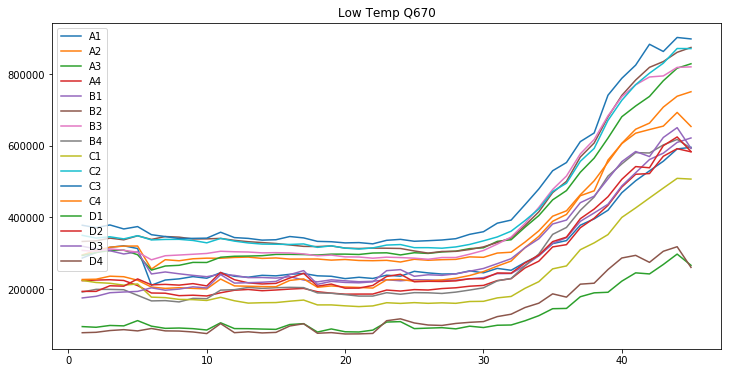

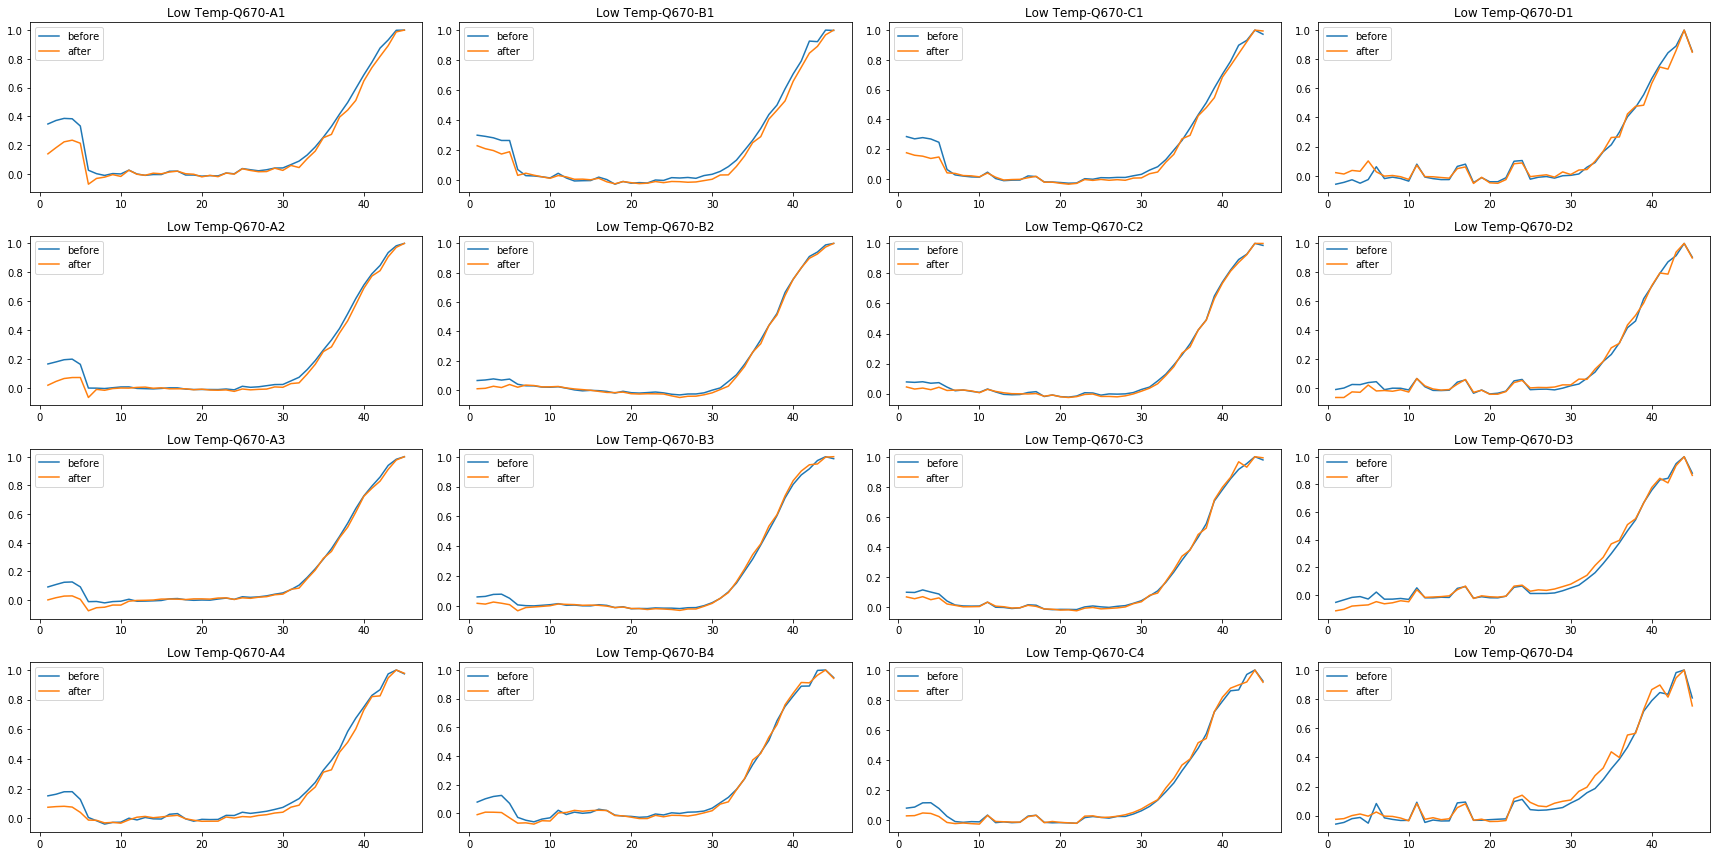

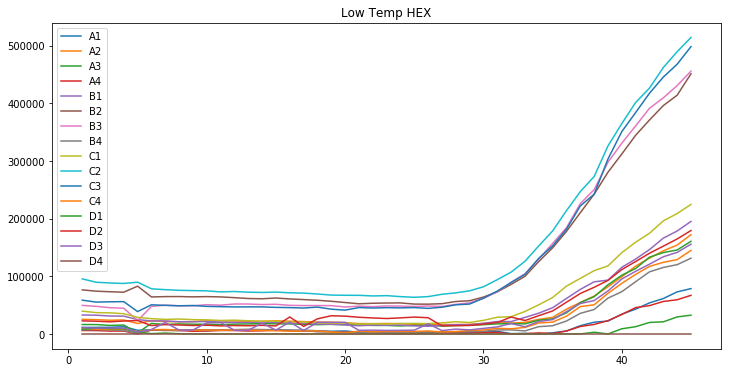

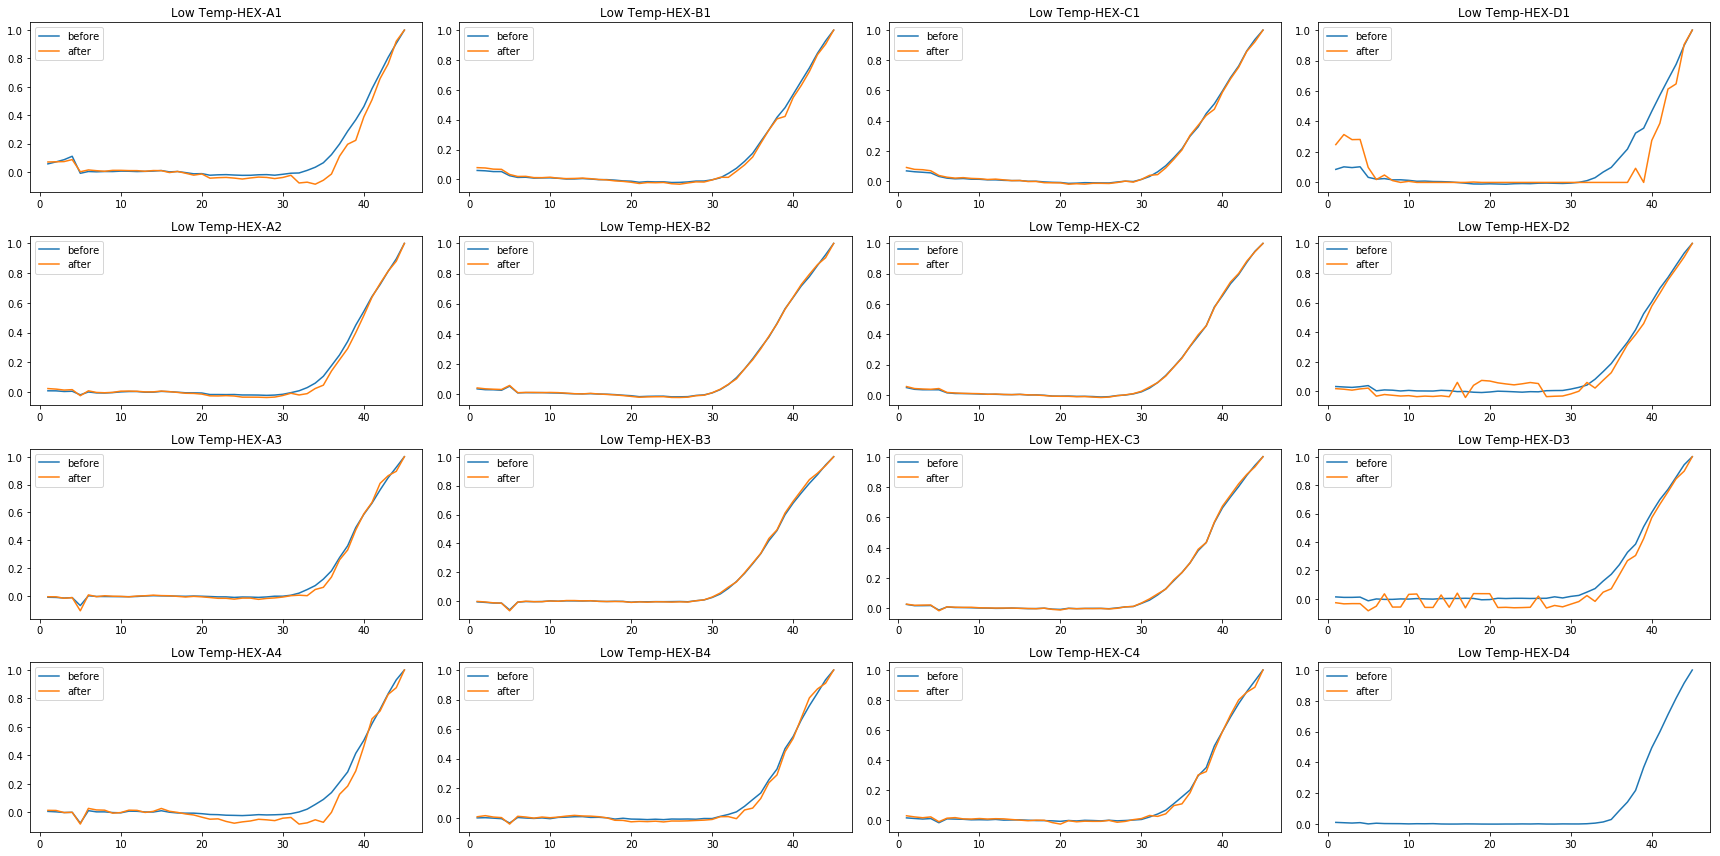

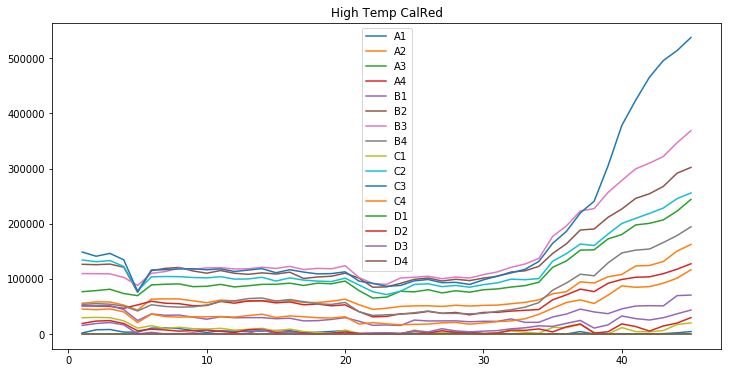

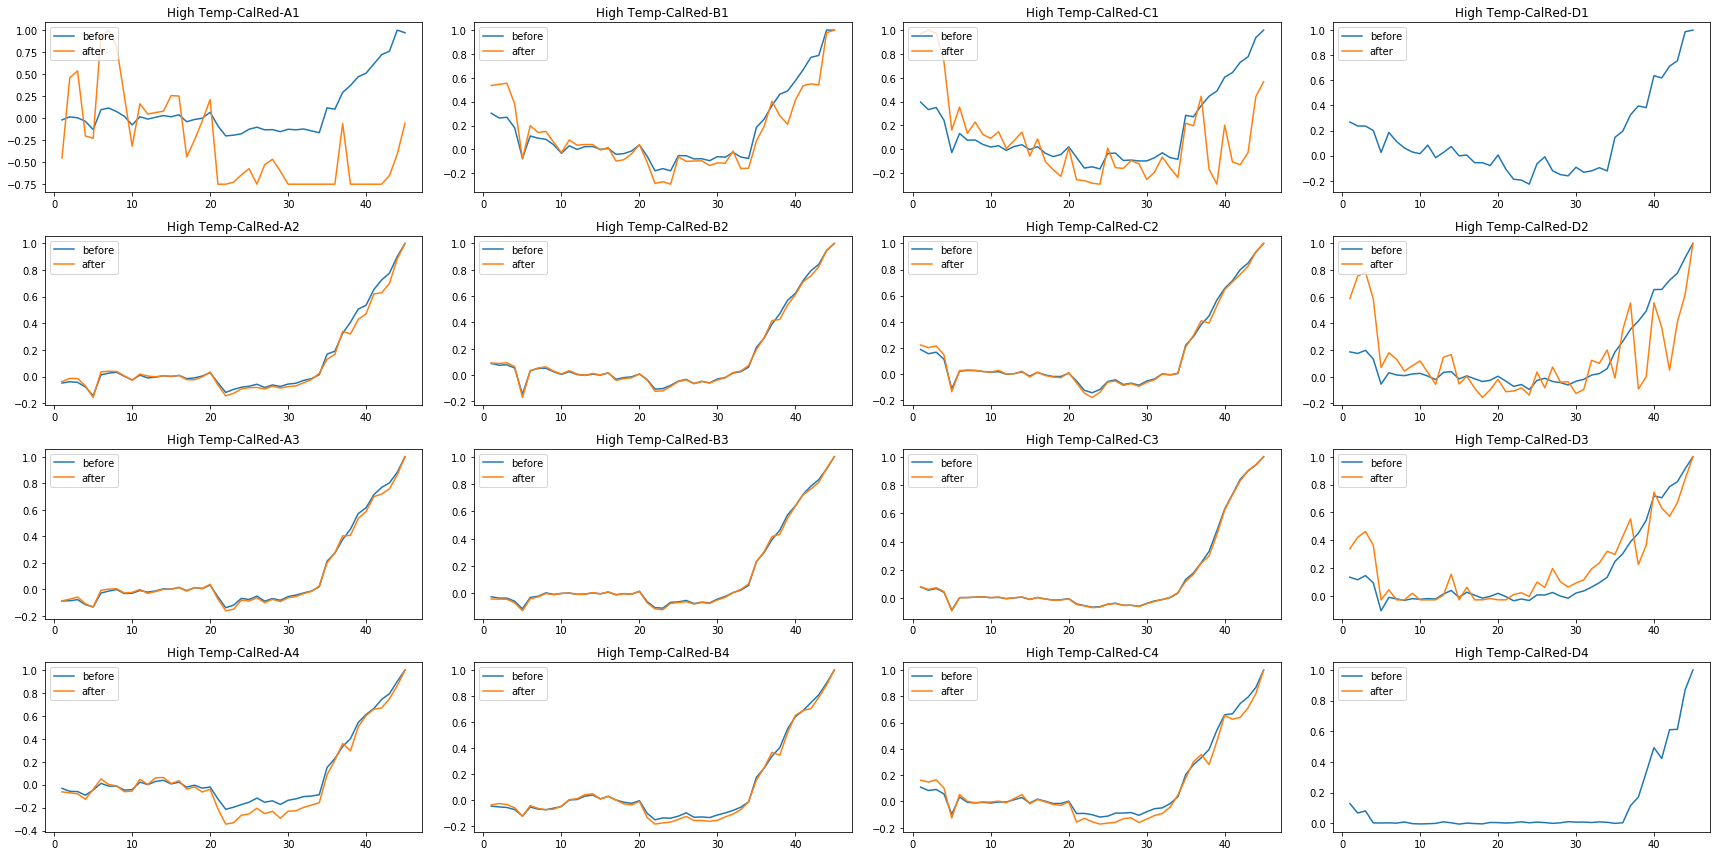

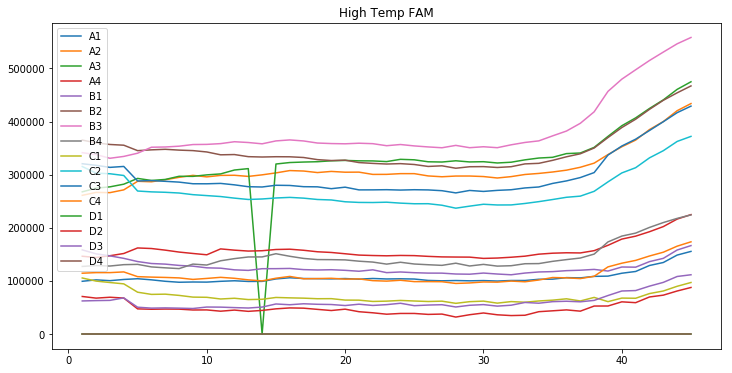

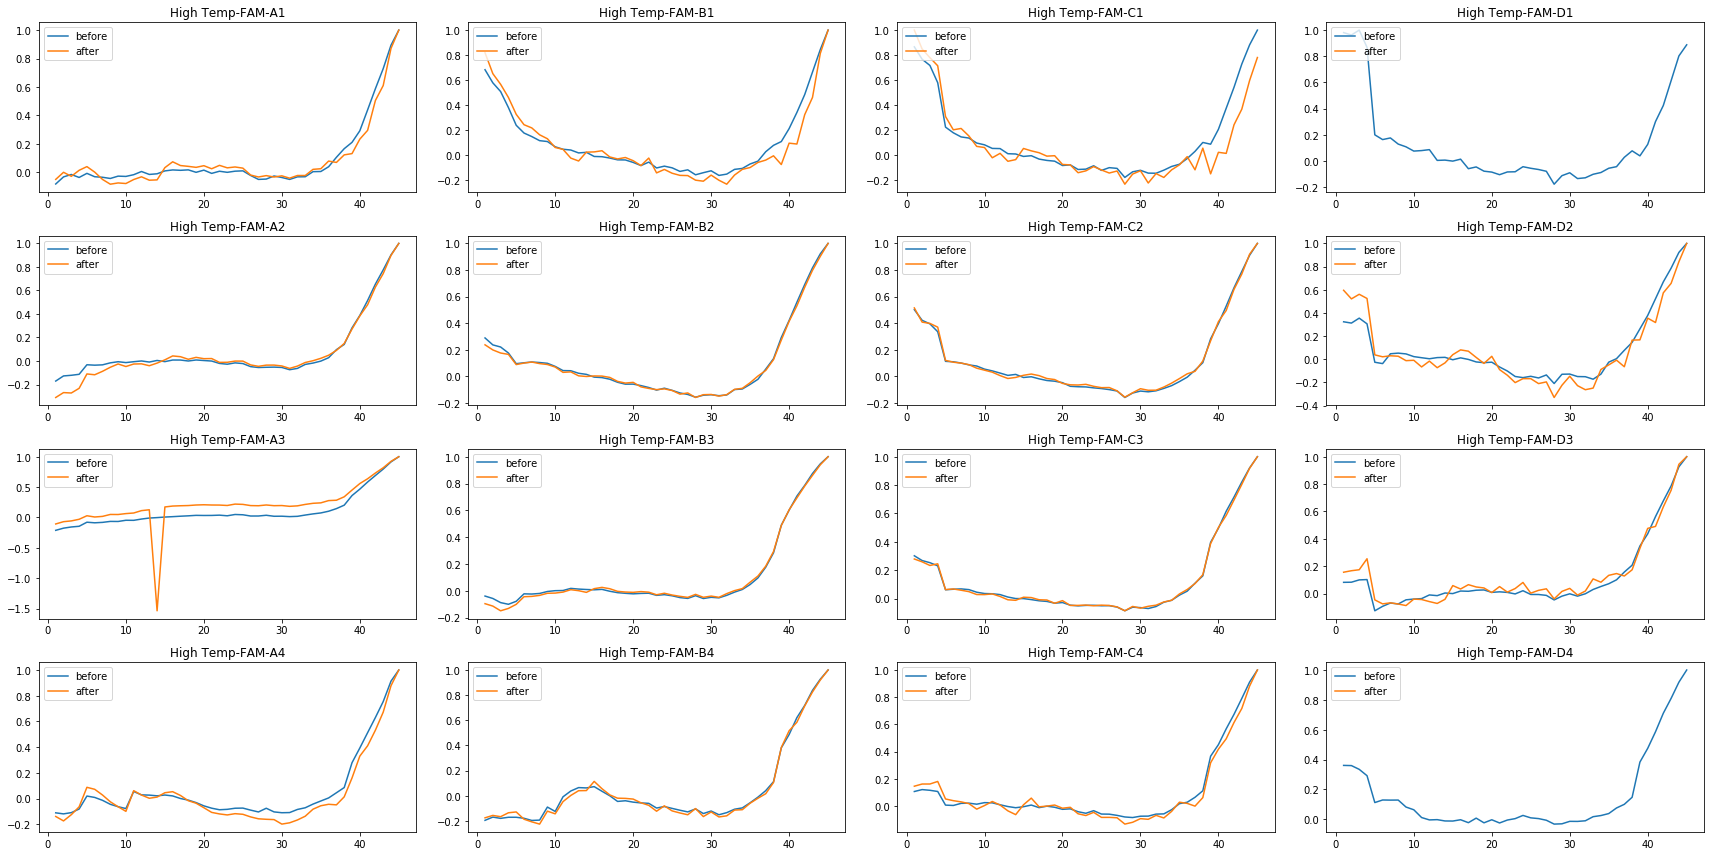

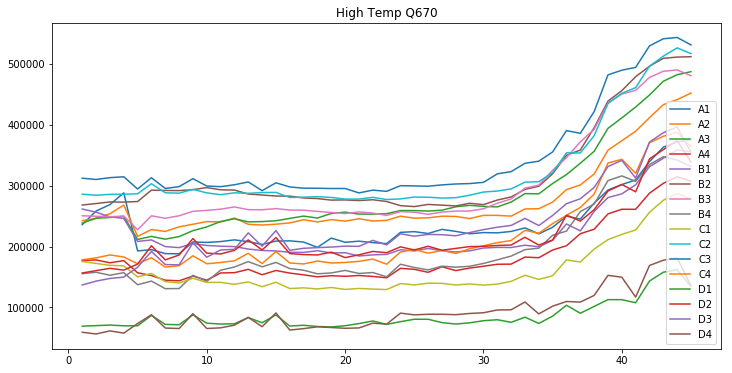

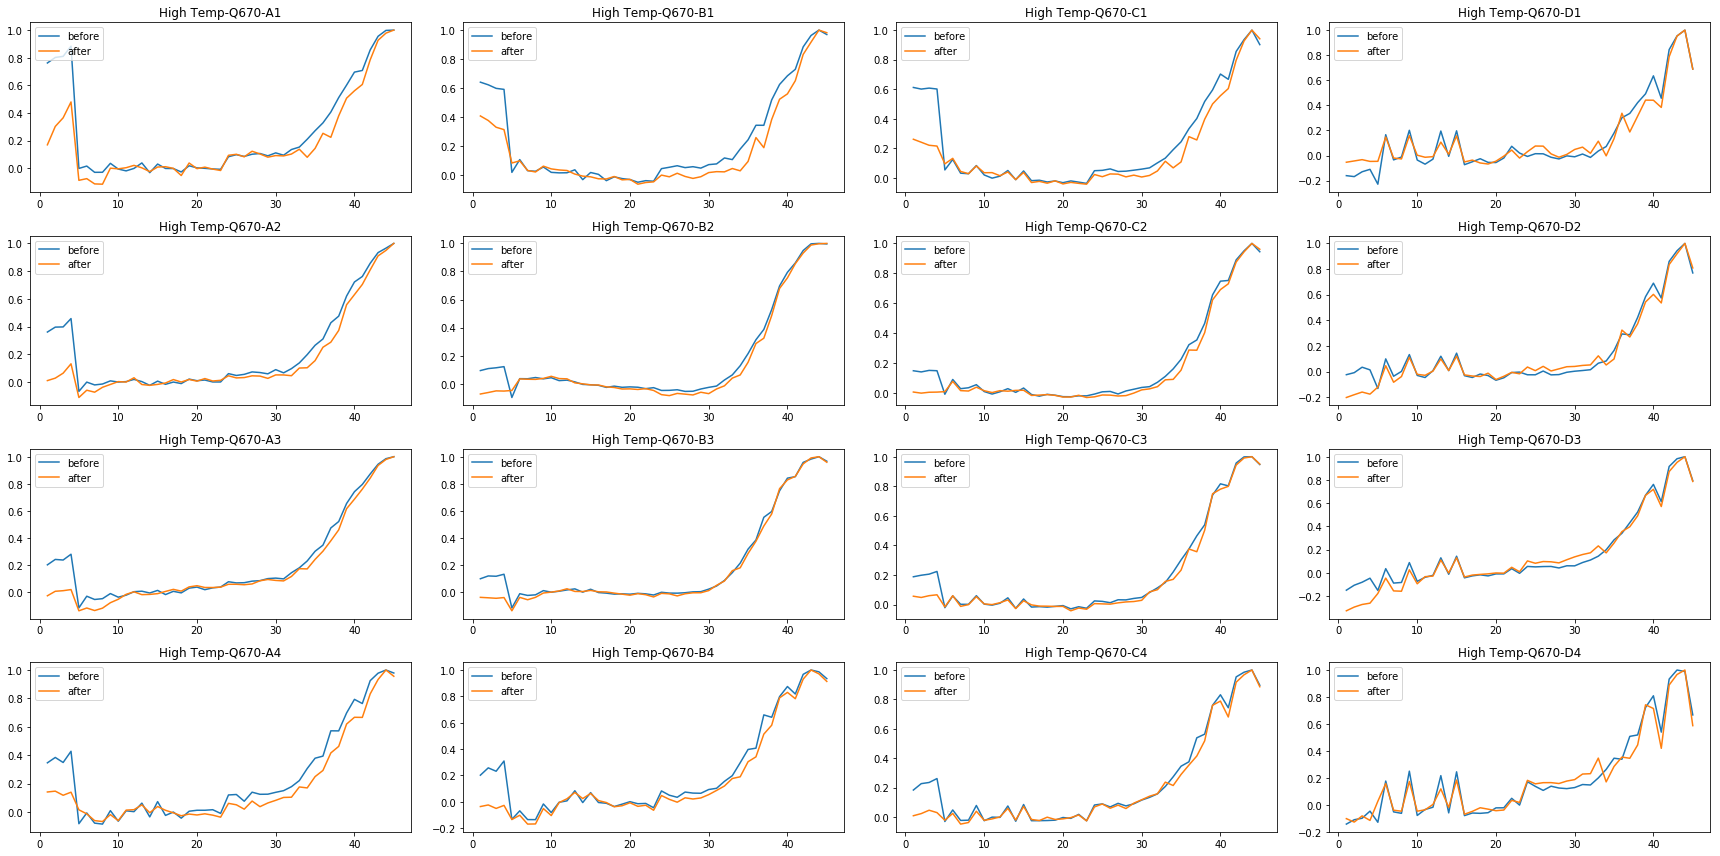

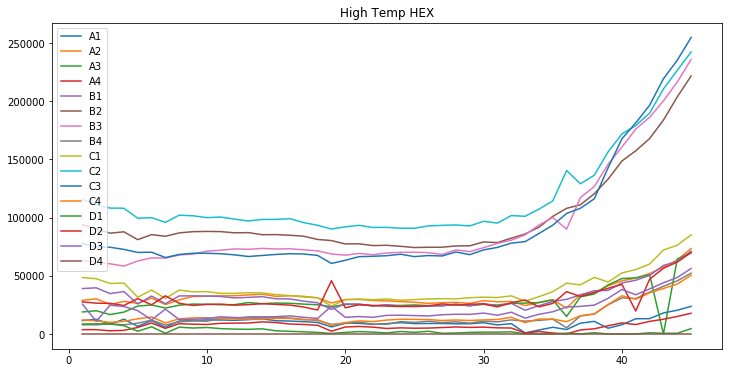

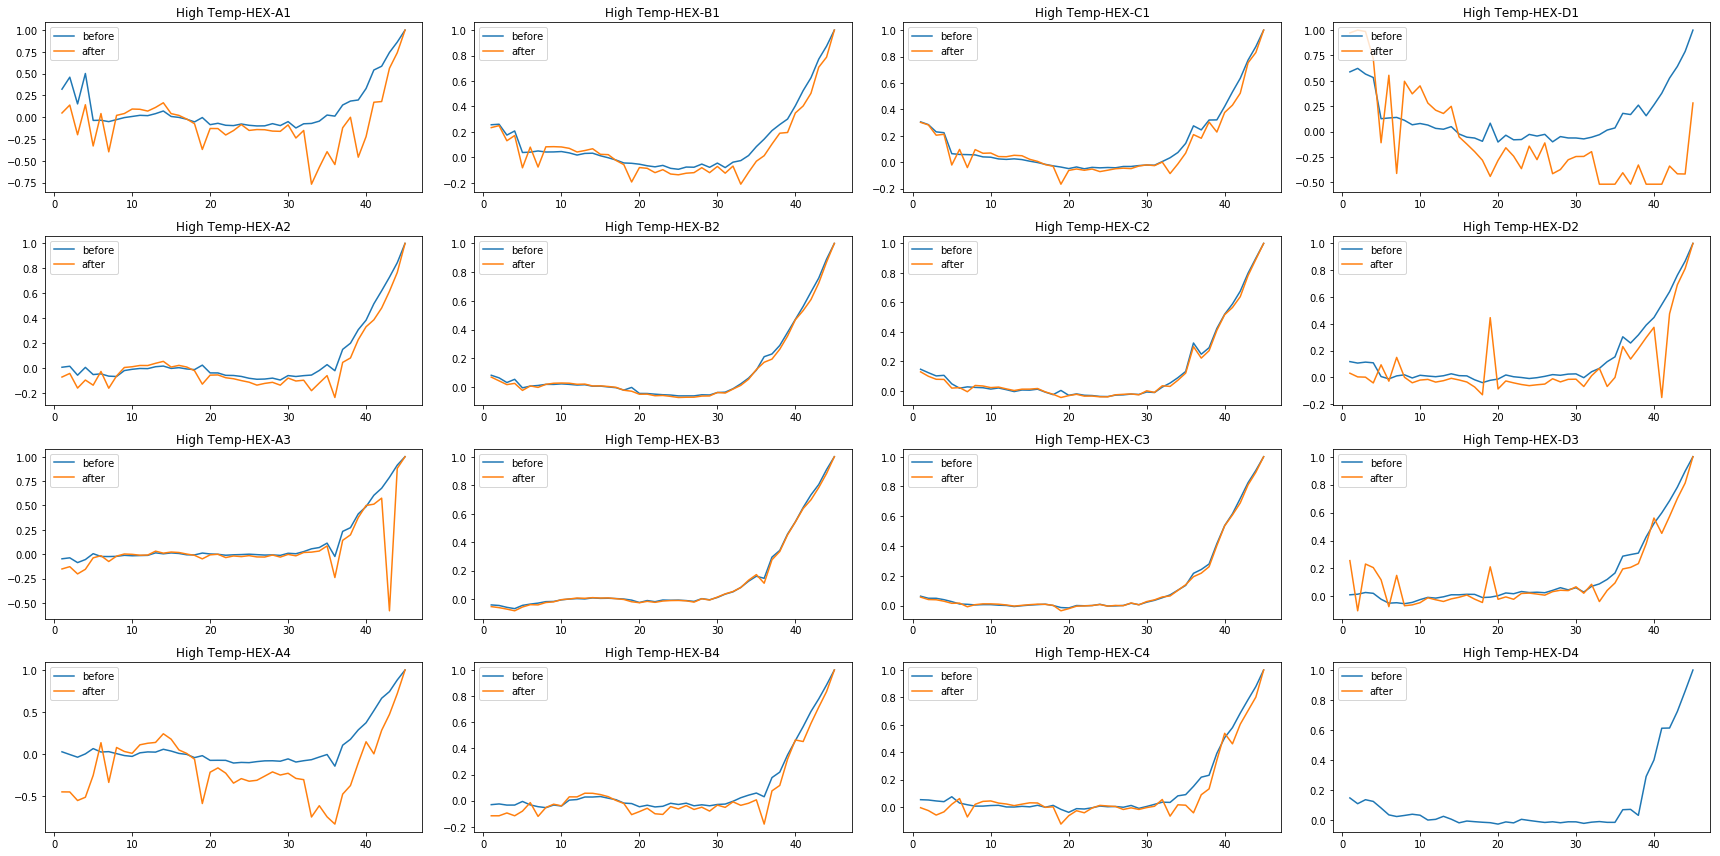

In [24]:
for temp in result_dict['rfu_sum'].keys():
    for ch, _dict in result_dict['rfu_sum'][temp].items():
        df = pd.DataFrame(_dict)
        df.index = range(1, 46)
        df = df.reindex(sorted(df.columns), axis=1)
        fig = df.plot(figsize=(12, 6), title=f'{temp} {ch}').get_figure()
        fig.savefig(f'camera2_intensity_otsu_{temp}_{ch}.png')
        
        key_before = map_dict[ch]+map_dict[temp[0]]
        df_before = dict_before[key_before]
        df_before.columns = col_li
        df_before.index = range(1, len(df_before)+1)
        
        df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
        df_norm = (df-df.loc[10:20].mean())/(df.max()-df.loc[10:20].mean())
        
        fig, axes = plt.subplots(4, 4, figsize=(24, 12))
        n = 0
        for col in df_norm.columns:
            i = n%4
            j = n//4
            axes[i, j].plot(df_before_norm[col], label='before')
            axes[i, j].plot(df_norm[col], label='after')
            axes[i, j].set_title(f'{temp}-{ch}-{col}')
            n += 1
            axes[i, j].legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(f'camera2_intensity_otsu_compare_{temp}_{ch}.png')

# investigate HEX

In [25]:
import matplotlib.patches as _patches

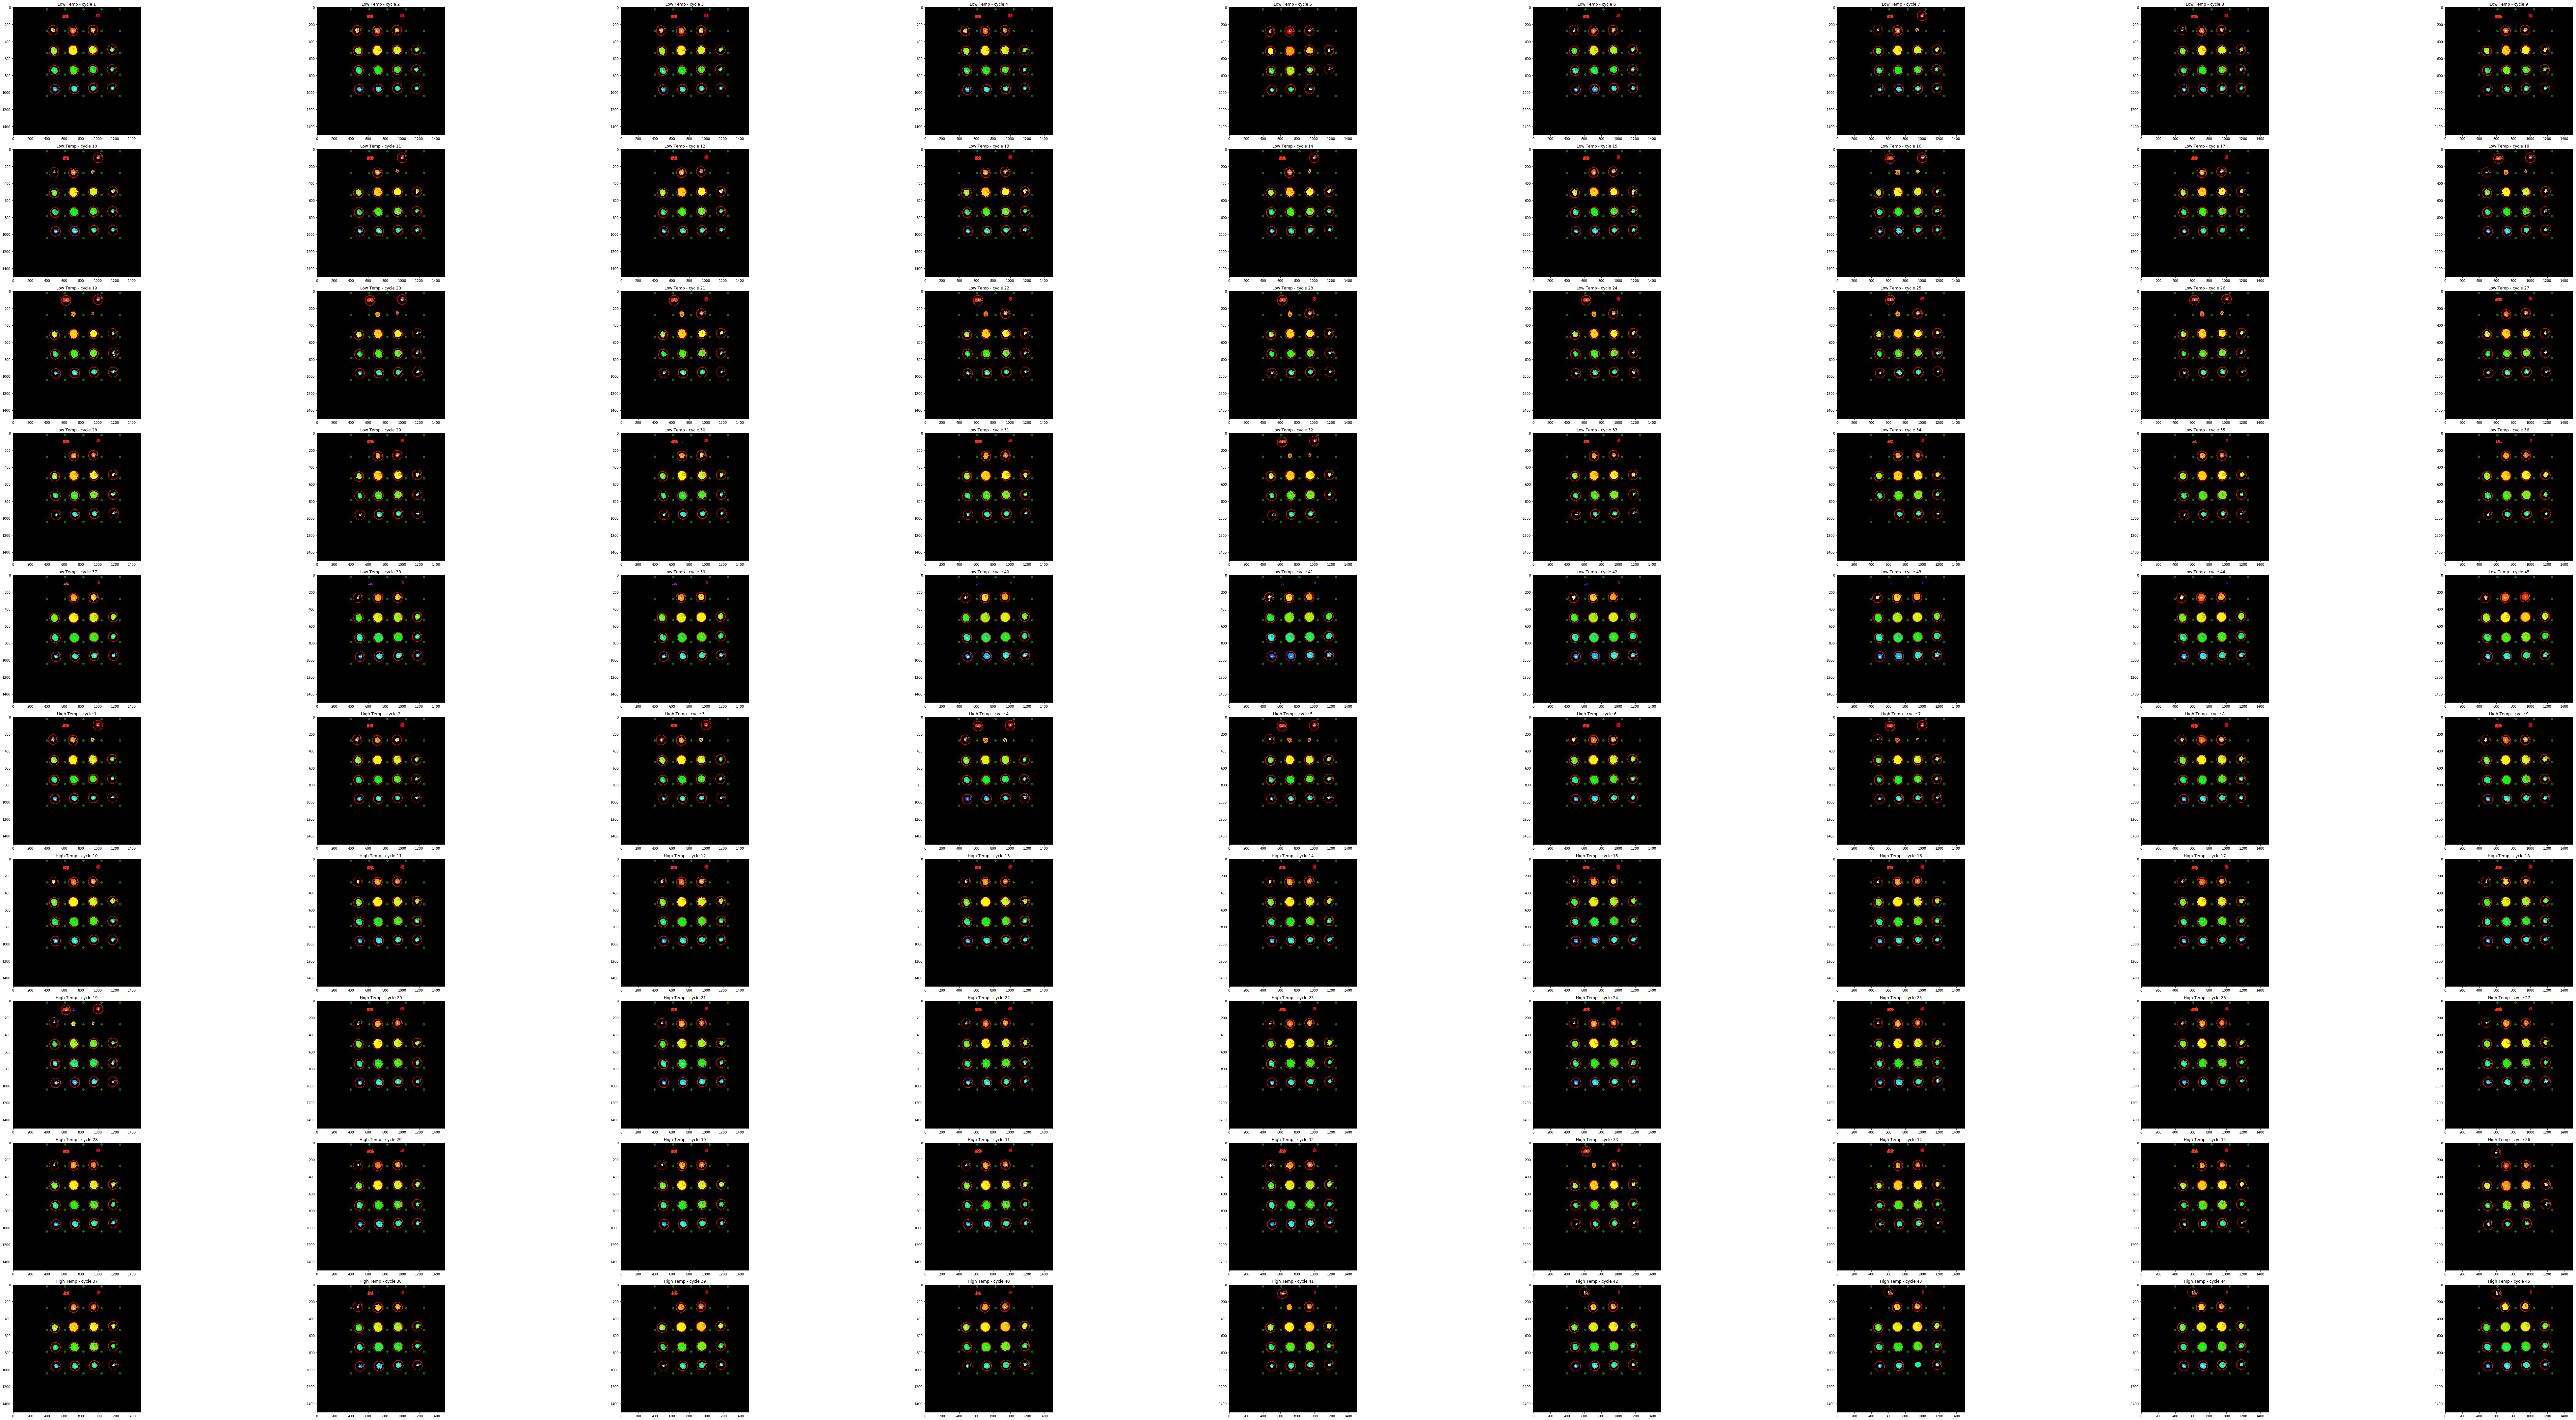

In [32]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict['HEX'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')
        
        sorted_region_key = list(im_dict['HEX'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
                
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['HEX'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['HEX'])
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['HEX'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('intensity_otsu_camera2_HEX_circle.png')
plt.show()

In [33]:
df_high_q = pd.DataFrame(region_intensity_dict['High Temp'])

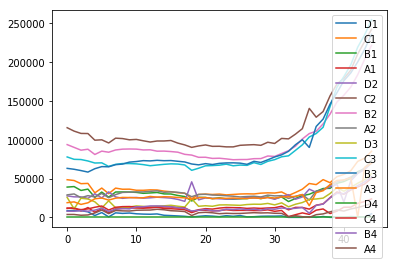

In [34]:
pd.DataFrame(region_intensity_dict['High Temp']).plot()

In [35]:
df_before = dict_before['qua72']
df_before.columns = col_li
df_before.index = range(1, len(df_before)+1)

In [36]:
df_high_q.index = range(1, 46)
df_high_q = df_high_q.reindex(sorted(df_high_q.columns), axis=1)

df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
df_high_q_norm = (df_high_q-df_high_q.loc[10:20].mean())/(df_high_q.max()-df_high_q.loc[10:20].mean())

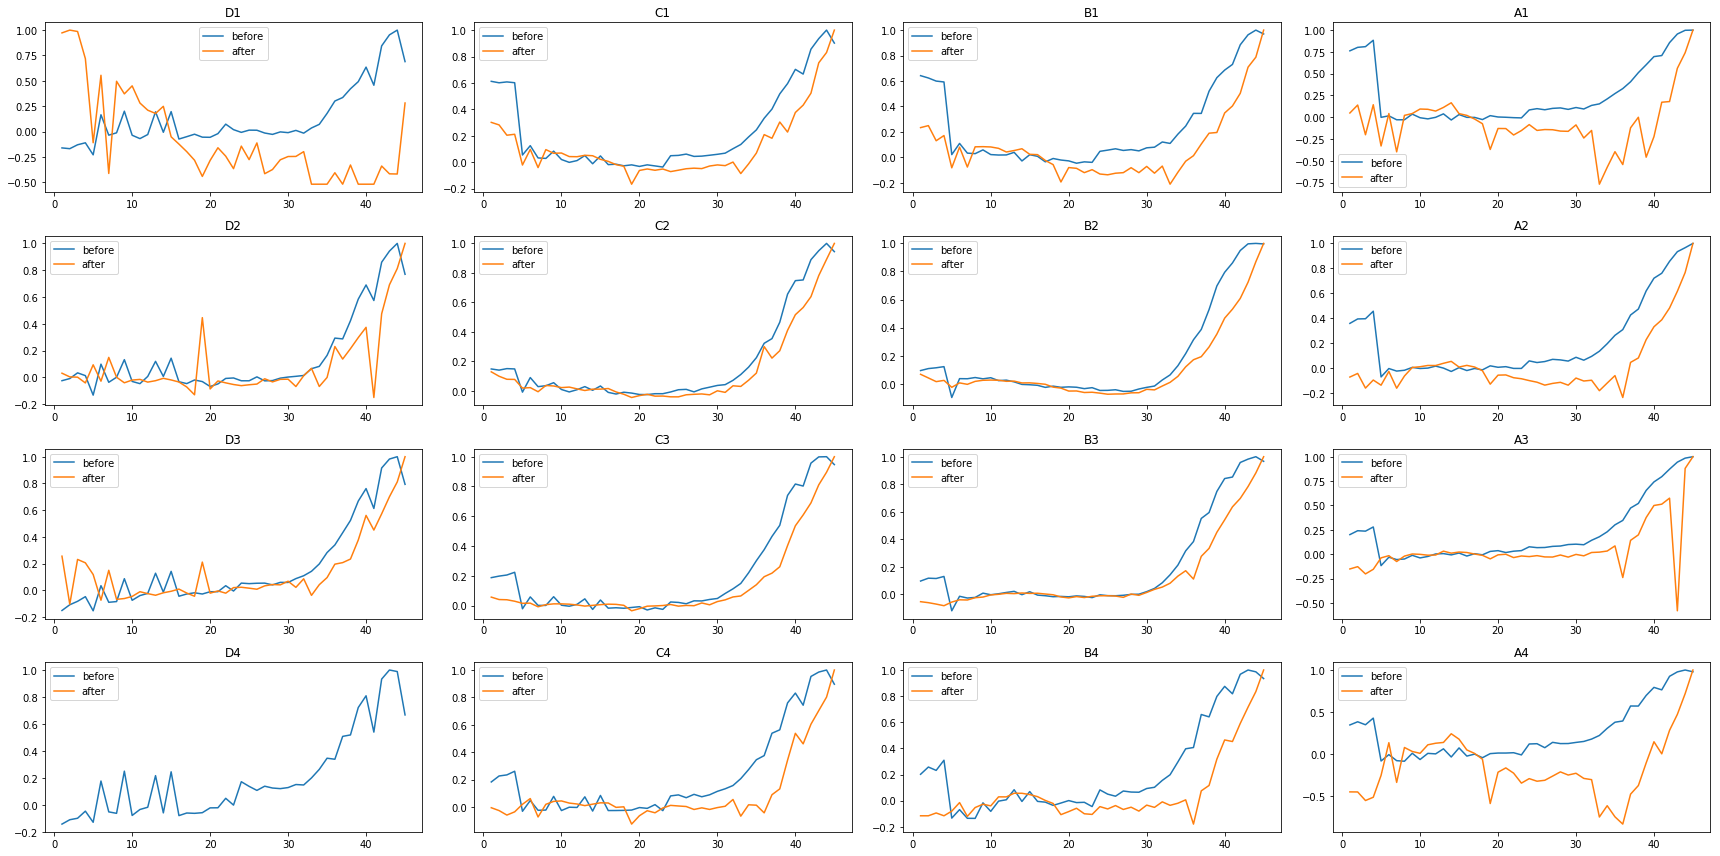

In [37]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
n = 0
for col in df_before_norm.columns:
    i = n%4
    j = n//4
    axes[i, j].plot(df_before_norm[col], label='before')
    axes[i, j].plot(df_high_q_norm[col], label='after')
    axes[i, j].set_title(col)
    n += 1
    axes[i, j].legend(loc='best')
plt.tight_layout()
plt.show()

# Low Cal Red

In [62]:
pts_x = []
pts_y = []
for key, val in result_dict['well_grid']['Low Temp']['CalRed'].items():
    y1, x1, y2, x2 = val
    pts_x.extend([x1, x2])
    pts_y.extend([y1, y2])

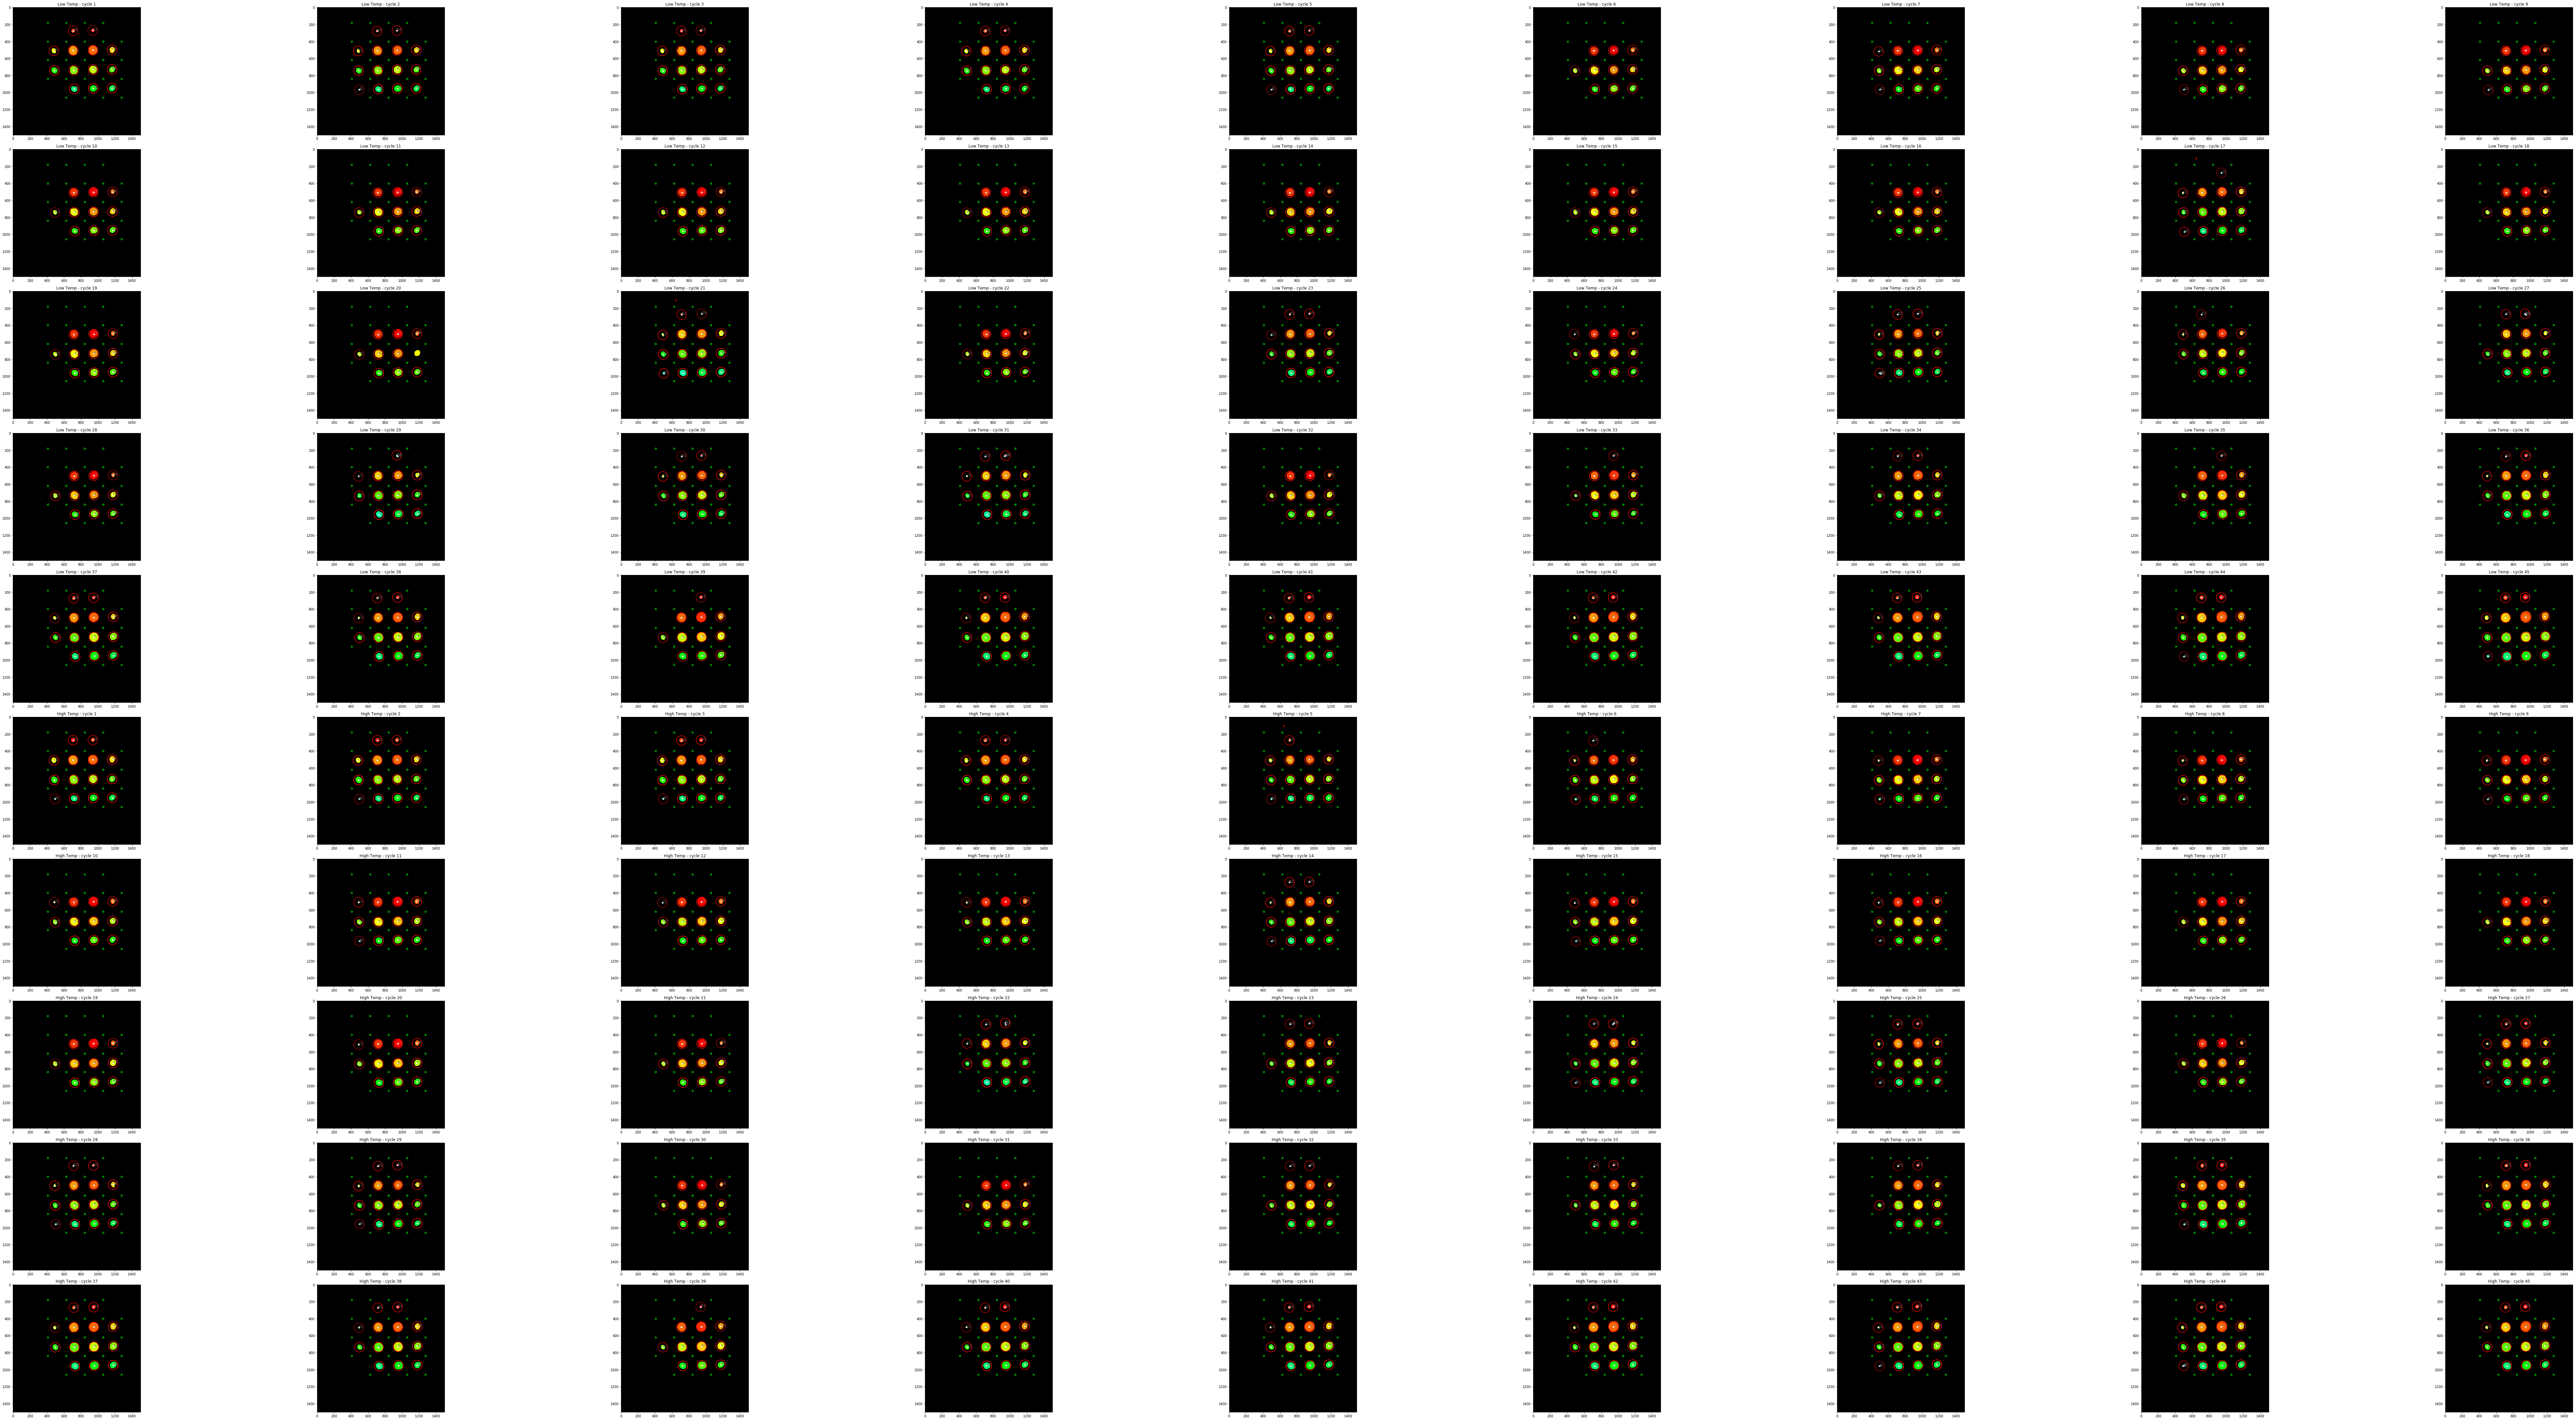

In [65]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45

    for c in range(45):
        im_labeled = im_dict['CalRed'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9

        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')

        sorted_region_key = list(im_dict['CalRed'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)

        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['CalRed'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['CalRed'])
            if grid is None:
                continue

            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['CalRed'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_calRed_circle.png')
plt.show()

In [67]:
im_dict['CalRed'][temp_li[0]][7]['orig']

KeyError: 'orig'

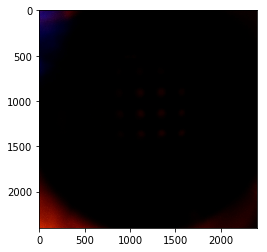

In [68]:
fpath = im_dir/'7_0_0.jpg'
im = np.array(Image.open(fpath))
plt.imshow(im)

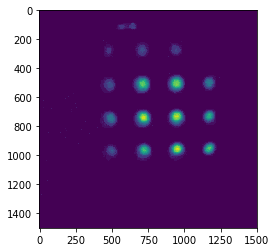

In [69]:
im_cropped = im[x_range, y_range]

im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
im_gray = im_hsv[:, :, 2]
plt.imshow(im_gray)

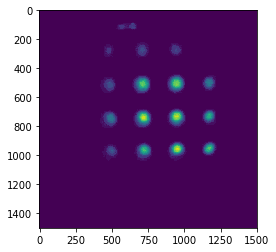

In [72]:
im_cropped = im[x_range, y_range]
plt.imshow(im_cropped[:, :, 0])

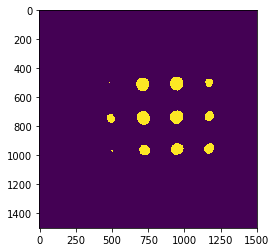

In [74]:
plt.imshow(im_dict['CalRed'][temp_li[0]][7]['thresh'])

# High HEX